In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
from census import Census
import json
import csv
import os


# Census API Key
#from config import api_key
c = Census("49f2db3e7faca8ecd92103d5bd5c5c765442d598", year=2016)


In [28]:
# Logic:
#Get the cites to query
#Get the census fields to query

#sourceFile = pd.ExcelFile('Project1_AmazonSites.xlsx')

sourceFile =  pd.ExcelFile(os.path.join('..','Project1_AmazonSites.xlsx'))

SitesDF=sourceFile.parse('AmazonSites') 

CitiesDf=sourceFile.parse('AmazonCities') 
CitiesDf=CitiesDf[['PlaceCode','StateCode']]

CensusFieldsDF=sourceFile.parse('CensusFields')
CensusFieldsMapDF = CensusFieldsDF[["Datafield","Category","CensusCode"]]
CensusFieldsDF = CensusFieldsDF[["Datafield","CensusCode"]]

#Converting the CensusFieldsDF into a dictionary.
dictCensusFields = CensusFieldsDF.set_index('CensusCode').to_dict()
dictCensusFields = dictCensusFields['Datafield']

print(dictCensusFields)
#CitiesDf.head()

{'B01002_001E': 'Median Age', 'B19013_001E': 'Median Household Income', 'B25077_001E': 'Median Home Value', 'B25064_001E': 'Median Rent', 'B23025_002E': 'LaborForce', 'B23025_004E': 'Emp_Total', 'B23025_003E': 'Civilian_labor_force', 'C24010_044E': 'Emp_Comp_Math_Female', 'C24010_040E': 'Emp_Mgment_Occp_Female', 'C24010_008E': 'Emp_Comp_Math_Male', 'C24010_006E': 'Emp_Mgment_Occp_Male', 'B15003_021E': 'Ed_Associates', 'B15003_022E': 'Ed_Bachelors', 'B15003_025E': 'Ed_Doctorate', 'B15003_018E': 'Ed_GED', 'B15003_017E': 'Ed_HighSchool', 'B15003_023E': 'Ed_Masters', 'B15003_024E': 'Ed_Professional', 'B01003_001E': 'Total Population', 'B02001_004E': 'Pop_American_Indian', 'B02001_005E': 'Population_Asian', 'B02001_003E': 'Pop_Black', 'B03001_003E': 'Pop_Hispanic_Origin', 'B02001_006E': 'Pop_Native_Hawaiian', 'B02001_007E': 'Pop_Other', 'B02001_008E': 'Pop_two_or_more_races', 'B02001_002E': 'Pop_White', 'B08136_001E': 'Commute_Time', 'B08136_004E': 'Commute_Time_Carpool', 'B08136_012E': 'Co

In [29]:

# Build your Census API call.
arrCensusFields = ['NAME']

for k in dictCensusFields.keys():
    arrCensusFields.append(k)
    
censusDF= pd.DataFrame()

for city in CitiesDf.values:
    cityCode = str(city[0])
    stateCode = str(city[1])

    if len(cityCode)==4:
        cityCode = "0"+cityCode
    if len(stateCode)==1:
        stateCode = "0"+stateCode
        
    varGeo = {'for':'place:'+ cityCode,'in':'state:'+stateCode}
    temp1 = c.acs5.get(arrCensusFields, varGeo)
  
    tempDF = pd.DataFrame(temp1[0], index = [0])    
    censusDF = censusDF.append(tempDF,ignore_index = True)


censusDF = censusDF.rename(columns=dictCensusFields)
censusDF.to_csv("Cities_Demographics.csv")



In [30]:
#Labor Force Statistics
CensusFieldsMapDF.head()

#Get the fields for Labor Force
laborForceFields = CensusFieldsMapDF.loc[CensusFieldsMapDF['Category'] == 'Employment',["Datafield"]]
laborForceFields.head(10)

#laborForceFieldsCols = 

dictLaborForceFields = laborForceFields.set_index('Datafield').to_dict()
dictLaborForceFields = laborForceFields['Datafield']
dictLFFields = ['NAME']
for value in dictLaborForceFields.values:
    dictLFFields.append(value)
    

laborForceDF= censusDF.loc[:,dictLFFields]

laborForceDF['Emp_Tech'] = laborForceDF['Emp_Comp_Math_Female']+laborForceDF['Emp_Mgment_Occp_Female']+laborForceDF['Emp_Comp_Math_Male']+laborForceDF['Emp_Mgment_Occp_Male']

laborForceDF['Emp_Tech_Per']=(laborForceDF['Emp_Tech']/laborForceDF['Emp_Total'])*100
laborForceDF = laborForceDF[['NAME','Emp_Total','Emp_Tech','Emp_Tech_Per']]
# Calculating the TechPool based on Percentage of employees in Tech, Business and Financial sectors.
laborForceDF = laborForceDF.sort_values(by = 'Emp_Tech_Per') 
laborForceDF = laborForceDF.reset_index(drop=True)
laborForceDF["TechPool_Score"] = laborForceDF.index+1

laborForceDF.head(10)


,NAME,Emp_Total,Emp_Tech,Emp_Tech_Per,TechPool_Score
0,"Los Angeles city, California",1903882.0,204933.0,10.763955,1
1,"New York city, New York",3991617.0,505311.0,12.659306,2
2,"Chicago city, Illinois",1290814.0,183995.0,14.254184,3
3,"Austin city, Texas",508510.0,87932.0,17.292089,4
4,"Boston city, Massachusetts",354352.0,62321.0,17.587314,5
5,"Raleigh city, North Carolina",235866.0,42197.0,17.890243,6
6,"Atlanta city, Georgia",220044.0,40477.0,18.394957,7
7,"Washington city, District of Columbia",348225.0,80445.0,23.101443,8


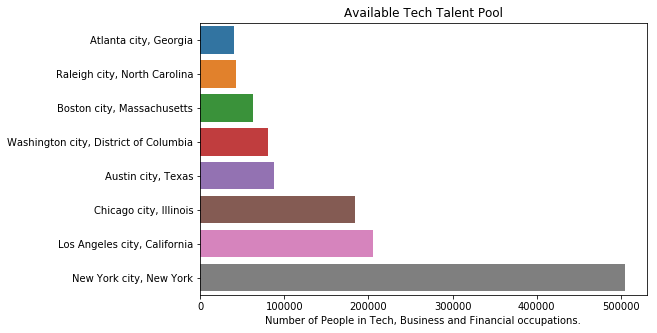

In [31]:
# Plotting Talent pool 
laborForceDF = laborForceDF.sort_values(by='Emp_Tech')
plt.figure(figsize=(8,5))
sns.barplot(y='NAME',x='Emp_Tech',data=laborForceDF)
plt.xlabel("Number of People in Tech, Business and Financial occupations.")
plt.ylabel("")
plt.title("Available Tech Talent Pool")

plt.savefig('Available_Tech_Pool_Raw.png', format='png', bbox_inches='tight')
plt.show()

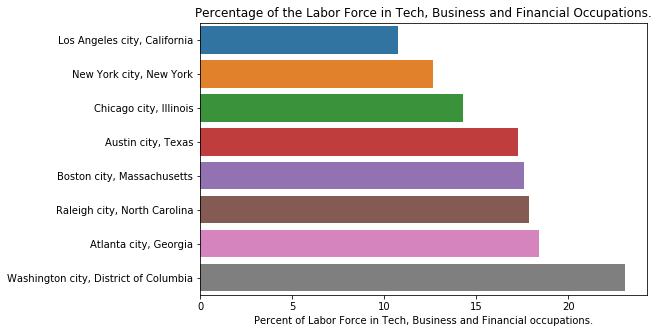

In [32]:

plt.figure(figsize=(8,5))
laborForceDF = laborForceDF.sort_values(by='Emp_Tech_Per')
sns.barplot(y='NAME',x='Emp_Tech_Per',data=laborForceDF)
plt.xlabel("Percent of Labor Force in Tech, Business and Financial occupations.")
plt.ylabel("")
plt.title("Percentage of the Labor Force in Tech, Business and Financial Occupations.")
plt.savefig('Percentage_oLaborForce_in_Tech.png', format='png', bbox_inches='tight')
plt.show()

In [33]:
#Educational Attainment Statistics

#Get the fields for Educational Attainment
EducationalAttainmentFields = CensusFieldsMapDF.loc[CensusFieldsMapDF['Category'] == 'Educational Attainment',["Datafield"]]
EducationalAttainmentFields.head(10)


dictEducationFields = EducationalAttainmentFields.set_index('Datafield').to_dict()
EducationalAttainmentFields = EducationalAttainmentFields['Datafield']
dictEDFields = ['NAME']
for value in EducationalAttainmentFields.values:
    dictEDFields.append(value)
    

laborEDDF= censusDF.loc[:,dictEDFields]

laborEDDF['Ed_Total'] =laborEDDF['Ed_Associates']+laborEDDF['Ed_Bachelors']+laborEDDF['Ed_Doctorate']+laborEDDF['Ed_GED']+laborEDDF['Ed_HighSchool']+laborEDDF['Ed_Masters']+laborEDDF['Ed_Professional']
laborEDDF['Ed_Total_Bachelors_or_Higher'] = laborEDDF['Ed_Bachelors']+laborEDDF['Ed_Doctorate']+laborEDDF['Ed_Masters']+laborEDDF['Ed_Professional']

laborEDDF['HigherEd_Per']=(laborEDDF['Ed_Total_Bachelors_or_Higher']/laborEDDF['Ed_Total'])*100

EducationalAttainmentFields.head(10)
laborEDDF['Per_HS'] =(laborEDDF['Ed_HighSchool']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_Assoc'] =(laborEDDF['Ed_Associates']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_Bachelors'] =(laborEDDF['Ed_Bachelors']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_Masters'] =(laborEDDF['Ed_Masters']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_Doctorate'] =(laborEDDF['Ed_Doctorate']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_GED'] =(laborEDDF['Ed_GED']/laborEDDF['Ed_Total'])*100
laborEDDF['Per_Prof'] =(laborEDDF['Ed_Professional']/laborEDDF['Ed_Total'])*100

# Calculating the Educational Attainment Rank based on 
#Percentage of people whose education level is bachelors or higher.

laborEDDF = laborEDDF.sort_values(by = 'HigherEd_Per', ascending=True) 
laborEDDF = laborEDDF.reset_index(drop=True)
laborEDDF["EduAtt_Score"] = laborEDDF.index+1

laborEDDF.head(10)

,NAME,Ed_Associates,Ed_Bachelors,Ed_Doctorate,Ed_GED,Ed_HighSchool,Ed_Masters,Ed_Professional,Ed_Total,Ed_Total_Bachelors_or_Higher,HigherEd_Per,Per_HS,Per_Assoc,Per_Bachelors,Per_Masters,Per_Doctorate,Per_GED,Per_Prof,EduAtt_Score
0,"New York city, New York",375851.0,1246538.0,85065.0,214018.0,1188696.0,610225.0,177697.0,3898090.0,2119525.0,54.373424,30.494319,9.641927,31.978174,15.654462,2.182223,5.490330,4.558566,1
1,"Los Angeles city, California",158229.0,566474.0,34199.0,41410.0,476667.0,187372.0,70748.0,1535099.0,858793.0,55.943819,31.051222,10.307413,36.901464,12.205858,2.227804,2.697546,4.608693,2
2,"Chicago city, Illinois",104276.0,399364.0,27854.0,51774.0,368819.0,188113.0,54335.0,1194535.0,669666.0,56.060810,30.875529,8.729422,33.432591,15.747801,2.331786,4.334239,4.548632,3
3,"Boston city, Massachusetts",20664.0,113854.0,13352.0,12763.0,81785.0,59571.0,19259.0,321248.0,206036.0,64.136119,25.458524,6.432414,35.441154,18.543617,4.156290,3.972943,5.995057,4
4,"Atlanta city, Georgia",14593.0,83300.0,6793.0,8852.0,50029.0,42727.0,15651.0,221945.0,148471.0,66.895402,22.541170,6.575052,37.531821,19.251166,3.060668,3.988375,7.051747,5
5,"Raleigh city, North Carolina",22290.0,91714.0,6010.0,6913.0,38696.0,35657.0,7709.0,208989.0,141090.0,67.510730,18.515807,10.665633,43.884606,17.061664,2.875749,3.307830,3.688711,6
6,"Austin city, Texas",31113.0,184101.0,13897.0,16485.0,83516.0,74426.0,18366.0,421904.0,290790.0,68.923262,19.795024,7.374426,43.635756,17.640506,3.293877,3.907287,4.353123,7
7,"Washington city, District of Columbia",14496.0,108252.0,19162.0,12052.0,71315.0,90366.0,38536.0,354179.0,256316.0,72.369056,20.135299,4.092846,30.564206,25.514217,5.410259,3.402799,10.880374,8


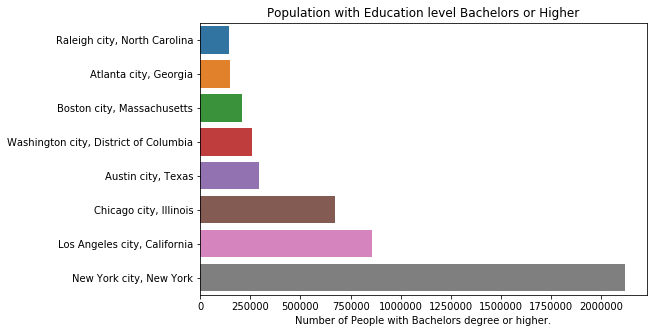

In [34]:
# Plotting EducationalAttainment
plt.figure(figsize=(8,5))
laborEDDF = laborEDDF.sort_values(by='Ed_Total_Bachelors_or_Higher')
sns.barplot(y='NAME',x='Ed_Total_Bachelors_or_Higher',data=laborEDDF)
plt.xlabel("Number of People with Bachelors degree or higher.")
plt.ylabel("")
plt.title("Population with Education level Bachelors or Higher")
plt.savefig('Pop_Education_Bachelors_Higher.png', format='png', bbox_inches='tight')
plt.show()

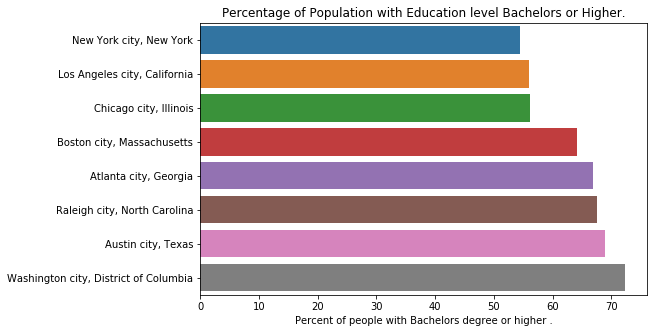

In [35]:
plt.figure(figsize=(8,5))
laborEDDF = laborEDDF.sort_values(by='HigherEd_Per')
sns.barplot(y='NAME',x='HigherEd_Per',data=laborEDDF)
plt.xlabel("Percent of people with Bachelors degree or higher .")
plt.ylabel("")
plt.title("Percentage of Population with Education level Bachelors or Higher.")
plt.savefig('Percent_Education_Bachelors_Higher.png', format='png', bbox_inches='tight')
plt.show()

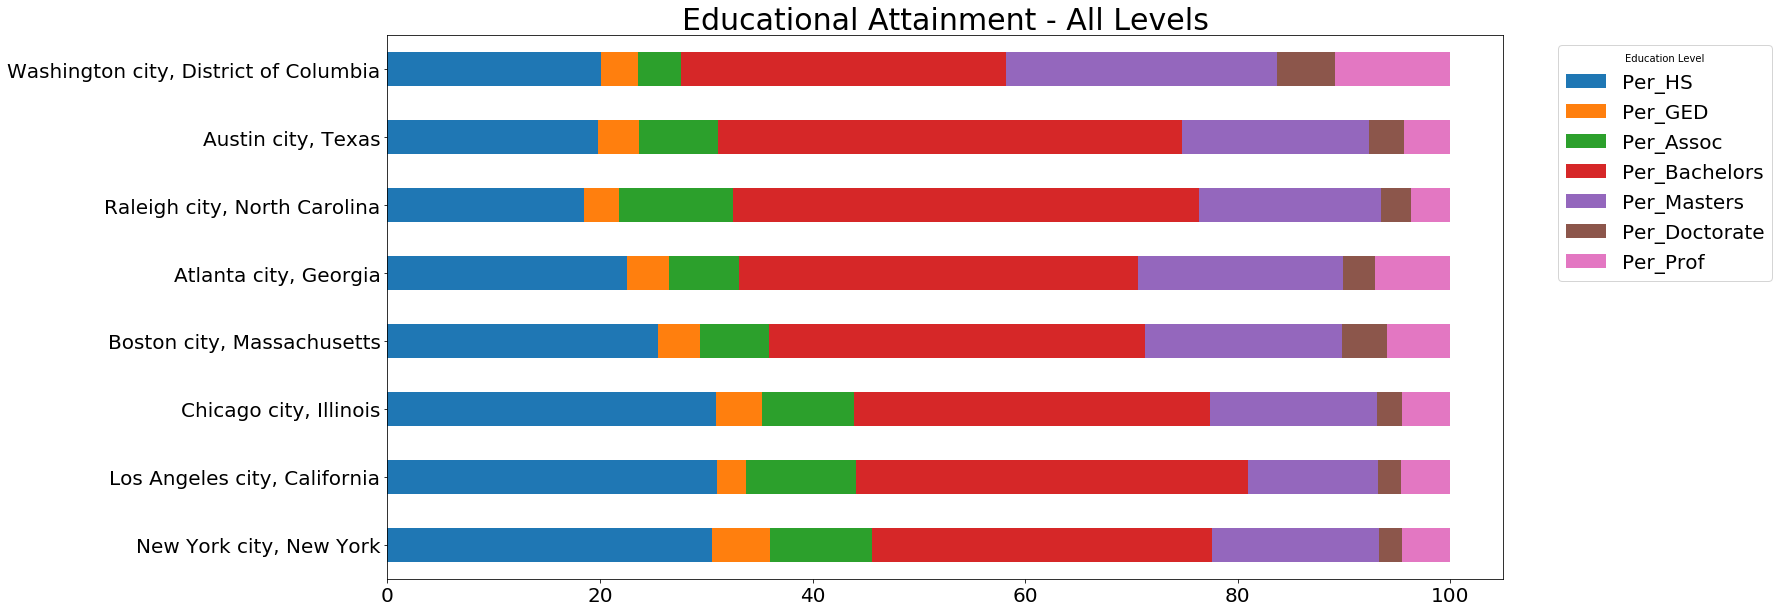

,Per_HS,Per_GED,Per_Assoc,Per_Bachelors,Per_Masters,Per_Doctorate,Per_Prof
NAME,,,,,,,
"New York city, New York",30.494319,5.490330,9.641927,31.978174,15.654462,2.182223,4.558566
"Los Angeles city, California",31.051222,2.697546,10.307413,36.901464,12.205858,2.227804,4.608693
"Chicago city, Illinois",30.875529,4.334239,8.729422,33.432591,15.747801,2.331786,4.548632
"Boston city, Massachusetts",25.458524,3.972943,6.432414,35.441154,18.543617,4.156290,5.995057
"Atlanta city, Georgia",22.541170,3.988375,6.575052,37.531821,19.251166,3.060668,7.051747


In [36]:
#Educational Attainment - ALL Categories
plt.figure(figsize=(12,6))
laborEDDF1  =laborEDDF.loc[:,['NAME','Per_HS','Per_GED','Per_Assoc','Per_Bachelors','Per_Masters','Per_Doctorate','Per_Prof']]
laborEDDF1 = laborEDDF1.set_index('NAME')
laborEDDF1.plot.barh(use_index = True,stacked=True,figsize=(20,10),fontsize = 20)

plt.legend(title = 'Education Level', fontsize=20,bbox_to_anchor=(1.25, 1), ncol=1)


plt.title("Educational Attainment - All Levels",fontsize = 30 )
        
plt.xlabel("")
plt.ylabel("")


plt.savefig('Educational_Attainment_All_Levels.png', format='png', bbox_inches='tight')
# xplt.set_yticklabels(['{:3.0f}%'.format(x*10) for x in range(11)])
plt.show()

laborEDDF1.head()

In [37]:
#Diversity

#Get the fields for Educational Attainment
DiversityFields = CensusFieldsMapDF.loc[CensusFieldsMapDF['Category'] == 'Population',["Datafield"]]
DiversityFields.head(10)


dictDiversityFields = DiversityFields.set_index('Datafield').to_dict()
DiversityFields = DiversityFields['Datafield']
dictDiversityFields = ['NAME']
for value in DiversityFields.values:
    dictDiversityFields.append(value)
    

DiversityDF= censusDF.loc[:,dictDiversityFields]
DiversityDF.head(10)
#laborEDDF['Ed_Total'] =laborEDDF['Ed_Associates']+laborEDDF['Ed_Bachelors']+laborEDDF['Ed_Doctorate']+laborEDDF['Ed_GED']+laborEDDF['Ed_HighSchool']+laborEDDF['Ed_Masters']+laborEDDF['Ed_Professional']
#laborEDDF['Ed_Total_Bachelors_or_Higher'] = laborEDDF['Ed_Bachelors']+laborEDDF['Ed_Doctorate']+laborEDDF['Ed_Masters']+laborEDDF['Ed_Professional']

#laborEDDF['HigherEd_Per']=(laborEDDF['Ed_Total_Bachelors_or_Higher']/laborEDDF['Ed_Total'])*100

DiversityDF['Per_White'] =((DiversityDF['Pop_White'])/DiversityDF['Total Population'])*100
DiversityDF['Per_Black'] =(DiversityDF['Pop_Black']/DiversityDF['Total Population'])*100
DiversityDF['Per_Asian'] =(DiversityDF['Population_Asian']/DiversityDF['Total Population'])*100
#DiversityDF['Per_Hispanic'] =(DiversityDF['Pop_Hispanic_Origin']/DiversityDF['Total Population'])*100
DiversityDF['Per_AmericanIndian'] =(DiversityDF['Pop_American_Indian']/DiversityDF['Total Population'])*100
DiversityDF['Per_Hawaiian'] =(DiversityDF['Pop_Native_Hawaiian']/DiversityDF['Total Population'])*100
DiversityDF['Per_Other'] =((DiversityDF['Pop_Other']+DiversityDF['Pop_two_or_more_races'])/DiversityDF['Total Population'])*100
DiversityDF.head(10)

,NAME,Median Age,Total Population,Pop_American_Indian,Population_Asian,Pop_Black,Pop_Hispanic_Origin,Pop_Native_Hawaiian,Pop_Other,Pop_two_or_more_races,Pop_White,Per_White,Per_Black,Per_Asian,Per_AmericanIndian,Per_Hawaiian,Per_Other
0,"Washington city, District of Columbia",33.8,659009.0,2174.0,24036.0,318598.0,69106.0,271.0,29650.0,18245.0,266035.0,40.368948,48.345015,3.647295,0.329889,0.041122,7.267731
1,"New York city, New York",35.9,8461961.0,33388.0,1159883.0,2064927.0,2457945.0,3995.0,1277265.0,277521.0,3644982.0,43.074909,24.402464,13.707024,0.394566,0.047211,18.373826
2,"Boston city, Massachusetts",31.7,658279.0,2577.0,61490.0,167282.0,125087.0,122.0,45492.0,32410.0,348906.0,53.002754,25.412021,9.341024,0.391475,0.018533,11.834192
3,"Chicago city, Illinois",33.9,2714017.0,7818.0,165229.0,839917.0,790548.0,906.0,310466.0,68357.0,1321324.0,48.685178,30.947374,6.087987,0.288060,0.033382,13.958019
4,"Los Angeles city, California",35.0,3918872.0,26660.0,452853.0,353023.0,1905577.0,6716.0,884822.0,139575.0,2055223.0,52.444249,9.008281,11.555698,0.680298,0.171376,26.140098
5,"Raleigh city, North Carolina",32.9,441326.0,1417.0,20299.0,127708.0,47723.0,368.0,17369.0,10998.0,263167.0,59.630976,28.937339,4.599548,0.321078,0.083385,6.427675
6,"Austin city, Texas",32.4,907779.0,3916.0,61926.0,68651.0,312822.0,743.0,55186.0,28700.0,688657.0,75.861746,7.562523,6.821704,0.431383,0.081848,9.240795
7,"Atlanta city, Georgia",33.5,456378.0,1308.0,18235.0,239005.0,21838.0,202.0,4802.0,10032.0,182794.0,40.053202,52.369965,3.995591,0.286605,0.044262,3.250376


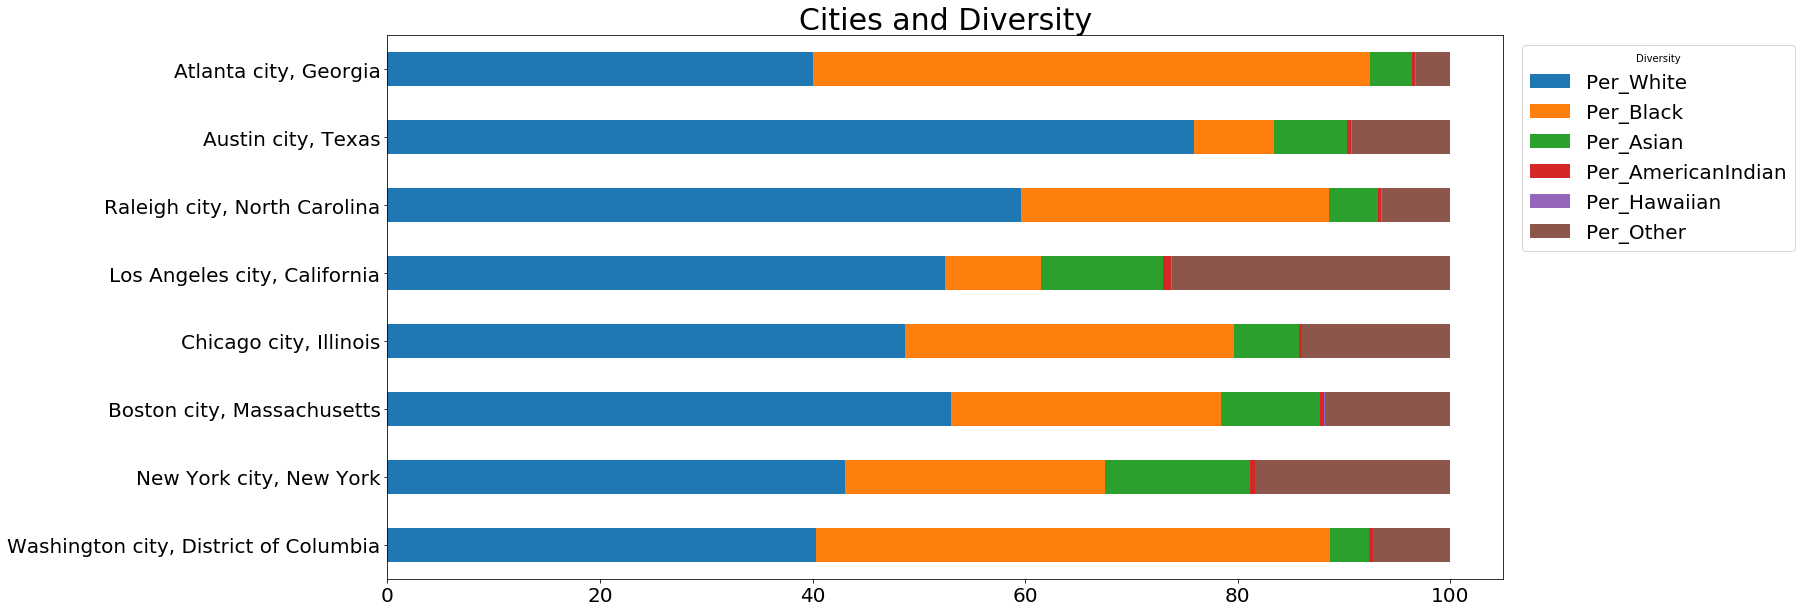

In [38]:
#How Diverse is your City?
plt.figure(figsize=(12,6))
DiversityDF1  =DiversityDF.loc[:,['NAME','Per_White','Per_Black','Per_Asian','Per_AmericanIndian','Per_Hawaiian','Per_Other']]
DiversityDF1 = DiversityDF1.set_index('NAME')
DiversityDF1.plot.barh(use_index = True,stacked=True,figsize=(20,10),fontsize = 20)
DiversityDF1.head(10)
plt.legend(title = 'Diversity', fontsize=20,bbox_to_anchor=(1.27, 1), ncol=1)

plt.title("Cities and Diversity",fontsize = 30 )

plt.xlabel("")
plt.ylabel("")
plt.savefig('Cities and Diversity_ALL.png', format='png', bbox_inches='tight')    


# xplt.set_yticklabels(['{:3.0f}%'.format(x*10) for x in range(11)])
plt.show()


In [39]:
#Diversity Score
#Source : https://wallethub.com/edu/most-diverse-cities/12690/
CitiesDiversityDf=sourceFile.parse('AmzonCities_DiversityRating') 
CitiesDiversityDf=CitiesDiversityDf[['NAME','DiversityScore']]
CitiesDiversityDf = CitiesDiversityDf.sort_values(by = 'DiversityScore', ascending=True) 
CitiesDiversityDf = CitiesDiversityDf.reset_index(drop=True)
CitiesDiversityDf["Diversity_Score"] = CitiesDiversityDf.index+1

CitiesDiversityDf.head(10)

,NAME,DiversityScore,Diversity_Score
0,"Atlanta city, Georgia",67.26,1
1,"Raleigh city, North Carolina",67.95,2
2,"Boston city, Massachusetts",68.96,3
3,"Washington city, District of Columbia",69.44,4
4,"Austin city, Texas",69.91,5
5,"Chicago city, Illinois",70.57,6
6,"Los Angeles city, California",70.84,7
7,"New York city, New York",71.73,8


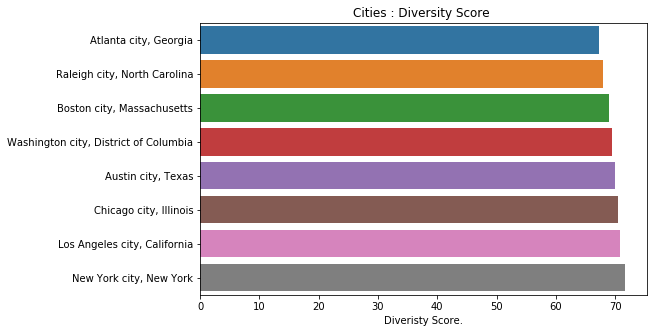

In [40]:
#Plotting Diversity score

plt.figure(figsize=(8,5))
CitiesDiversityDf = CitiesDiversityDf.sort_values(by='DiversityScore')
sns.barplot(y='NAME',x='DiversityScore',data=CitiesDiversityDf)
plt.xlabel("Diveristy Score.")
plt.ylabel("")

plt.title("Cities : Diversity Score ")
plt.savefig('Cities_Diversity_Scores.png', format='png', bbox_inches='tight') 
plt.show()


In [41]:
#Crime Score
#Source : city-data.com

CitiesCrimeDf=sourceFile.parse('AmzonCities_Crime') 
CitiesCrimeDf=CitiesCrimeDf[['NAME','CrimeIndex']]
CitiesCrimeDf = CitiesCrimeDf.sort_values(by = 'CrimeIndex', ascending=False) 
CitiesCrimeDf = CitiesCrimeDf.reset_index(drop=True)
CitiesCrimeDf["Crime_Score"] = CitiesCrimeDf.index+1

CitiesCrimeDf.head(10)

,NAME,CrimeIndex,Crime_Score
0,"Atlanta city, Georgia",591.8,1
1,"Washington city, District of Columbia",568.9,2
2,"Chicago city, Illinois",510.7,3
3,"Los Angeles city, California",347.1,4
4,"Austin city, Texas",312.7,5
5,"Boston city, Massachusetts",303.5,6
6,"Raleigh city, North Carolina",259.8,7
7,"New York city, New York",222.2,8


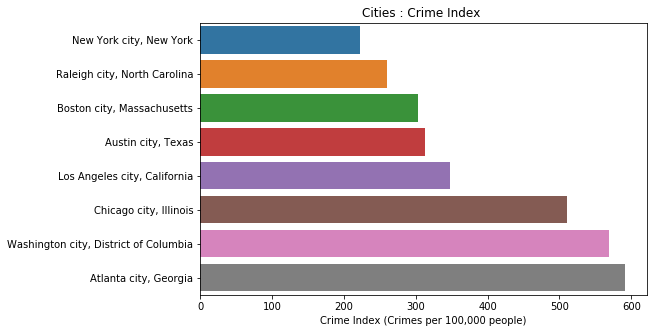

In [42]:
#Plotting Crime Index

plt.figure(figsize=(8,5))
CitiesCrimeDf = CitiesCrimeDf.sort_values(by='CrimeIndex')
sns.barplot(y='NAME',x='CrimeIndex',data=CitiesCrimeDf)
plt.xlabel("Crime Index (Crimes per 100,000 people)")
plt.ylabel("")

plt.title("Cities : Crime Index ")
plt.savefig('Cities_Diversity_Scores.png', format='png', bbox_inches='tight') 
plt.show()

In [43]:
#Demographics Scores
# Tech Pool, Education Attainment Diversity,Crime and Diversity Scores.

TechPoolEduAttDf = pd.merge(laborForceDF,laborEDDF, on= 'NAME')
TechPoolEduAttDf = TechPoolEduAttDf[['NAME','TechPool_Score','EduAtt_Score']]
TechPoolEduAttDf.head(10)

DiversityCrimeDf = pd.merge(CitiesCrimeDf,CitiesDiversityDf, on= 'NAME')
DiversityCrimeDf = DiversityCrimeDf[['NAME','Crime_Score','Diversity_Score']]
DiversityCrimeDf.head(10)

DemographicsScoresDf1 = pd.merge(TechPoolEduAttDf,DiversityCrimeDf, on= 'NAME')

CitiesDf=sourceFile.parse('AmazonCities') 
CitiesDf = CitiesDf[['NAME','City']]

DemographicsScoresDf = pd.merge(CitiesDf,DemographicsScoresDf1, on= 'NAME')
DemographicsScoresDf.head(10)

,NAME,City,TechPool_Score,EduAtt_Score,Crime_Score,Diversity_Score
0,"Washington city, District of Columbia",Washington DC,8,8,2,4
1,"New York city, New York",New York,2,1,8,8
2,"Boston city, Massachusetts",Boston,5,4,6,3
3,"Chicago city, Illinois",Chicago,3,3,3,6
4,"Los Angeles city, California",Los Angeles,1,2,4,7
5,"Raleigh city, North Carolina",Raleigh,6,6,7,2
6,"Austin city, Texas",Austin,4,7,5,5
7,"Atlanta city, Georgia",Atlanta,7,5,1,1


In [44]:
DemographicsScoresDf.to_csv("Cities_Demographics_Scores.csv")